# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD, [tomorrowdata.io](https://tomorrowdata.io)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numbers import Number

# credits and installation https://github.com/njchiang/tikhonov.git
from tikhonov.TikhonovRegression import Tikhonov

from sklearn.linear_model import LinearRegression
from scipy import stats

# Two data sources

We have two official data sources:

- ISS data (Istituto Superiore della Sanita')
- pcm-dpc data (Protezione Civile)

See https://www.epicentro.iss.it/coronavirus/sars-cov-2-sorveglianza , at "Perché le informazioni fornite dall’ISS possono differire (essere in ritardo) rispetto a quelle della Protezione civile"


## ISS data (Istituto Superiore della Sanita')

These data are available via the Ministero della Sanita' web site, not in their raw format, but only via descriptive reports.

To obtain the data  one needs to navigate (or scrape) the intricated and non standardized structure of the weekly reports from ministero della Sanita'

What follows is the result of the scraping, aimed to obtain the $Rt$ values computed by ISS.

In the "url" column the url to the official report is reported.

In [2]:
ISS_Rt = pd.read_csv(
    './data/sources/Rt_from_ISS.csv',
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [59]:
ISS_Rt.head()

,ID,report_time_range_descr,computation_time_range_descr,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,notes,source,source_detail,url
0,5169,2 - 8 novembre,22 ottobre - 4 novembre,2020-10-22,2020-11-04,1.43,1.08,1.81,NaN,attachement,imgs/C_17_notizie_5169_0_file.pdf,http://www.salute.gov.it/portale/nuovocoronavi...
1,5157,26 ottobre - 1 novembre,15 - 28 ottobre,2020-10-15,2020-10-28,1.72,1.45,1.83,NaN,attachement,/portale/news/documenti/Epi_aggiornamenti/alle...,http://www.salute.gov.it/portale/nuovocoronavi...
2,5146,19 - 25 ottobre,08 - 21 ottobre 2020,2020-10-08,2020-10-21,1.70,1.49,1.85,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...
3,5137,12-18 ottobre,01 - 14 ottobre 2020,2020-10-01,2020-10-14,1.50,1.09,1.75,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...
4,5125,5-11 ottobre,24 settembre - 07 ottobre,2020-09-24,2020-10-07,1.17,1.03,1.50,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...


In [4]:
ISS_Rt_clean = ISS_Rt.loc[:,[
    'computation_time_range_start','computation_time_range_end','Rt','Rt_95_min','Rt_95_max'
]].dropna()

In [5]:
ISS_Rt_clean['Rt_95_err_max'] = ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt
ISS_Rt_clean['Rt_95_err_min'] = np.abs(ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt)

In [6]:
ISS_Rt_clean['Rt_reference_date'] = (
    ISS_Rt_clean.computation_time_range_start + 
    (ISS_Rt_clean.computation_time_range_end - ISS_Rt_clean.computation_time_range_start)/2
)

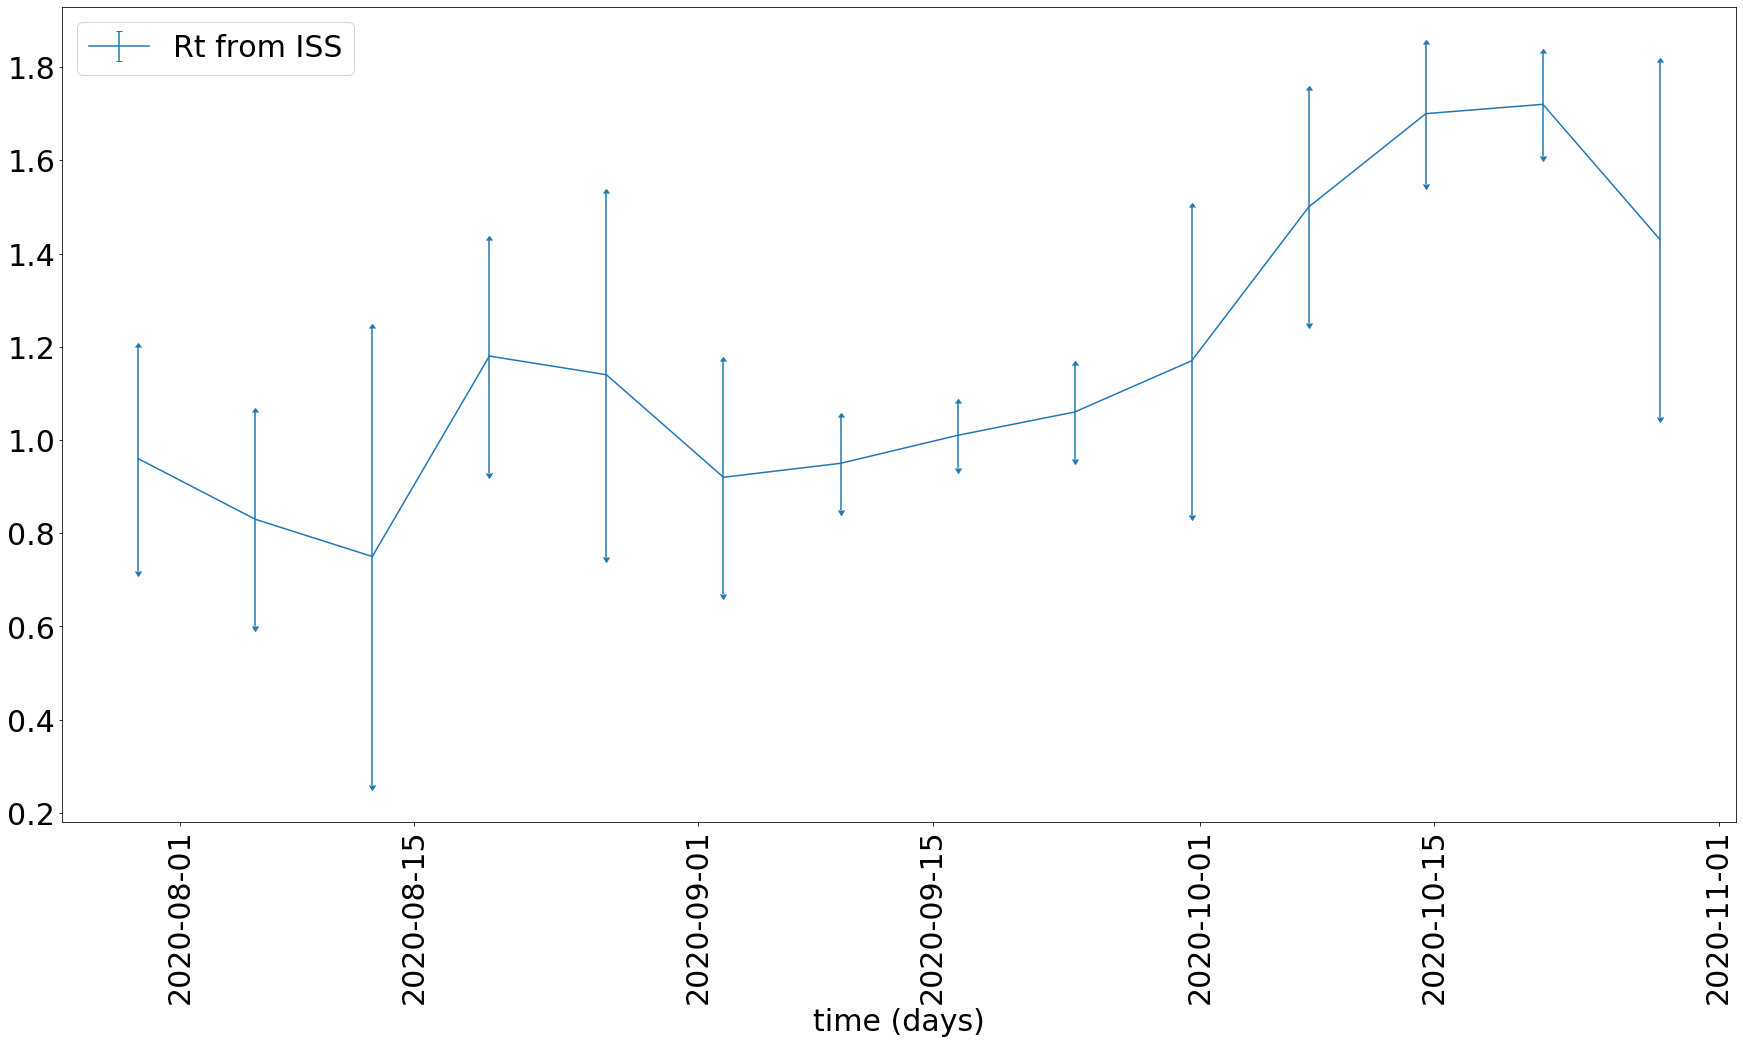

In [7]:
fig, ax1 = plt.subplots(figsize=(30,15))

ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylabel('', fontsize=30)
ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS'
)

_ = ax1.legend(fontsize=30)

By the way, this happens to be the only publicly available chart of the ISS computed Rt value, at least to my knowledge.

# Get pcm-dpc/COVID-19 data

In [8]:
def parse_date_pcm(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [9]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date_pcm
)

In [10]:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

# https://arxiv.org/pdf/2004.04529.pdf

# https://github.com/Keystone-Strategy/covid19-intervention-data/

# https://coviz.apps.allenai.org/

In [60]:
italy_raw_data.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,casi_da_screening_smoothed,casi_da_sospetto_diagnostico_smoothed,nuovi_positivi_Rt,nuovi_casi_da_sospetto_diagnostico_Rt,nuovi_casi_da_screening_Rt,nuovi_positivi_smoothed_Rt,nuovi_casi_da_sospetto_diagnostico_smoothed_Rt,nuovi_casi_da_screening_smoothed_Rt,perturbation_Rt,casi_da_sospetto_diagnostico_smoothed_perturbed_Rt
0,2020-02-24 23:59:00,ITA,101,26,127,94,221,0,221,1,...,-0.000002,-0.000039,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-02-25 23:59:00,ITA,114,35,150,162,311,90,93,1,...,-0.000002,-0.000043,5.728905,0.0,0.0,37.777166,-14.503751,3.422681,23.175439,-17.356356
2,2020-02-26 23:59:00,ITA,128,36,164,221,385,74,78,3,...,-0.000004,-0.000079,2.667423,0.0,0.0,16.707250,-354.284820,-21.571595,9.619766,-1533.679460
3,2020-02-27 23:59:00,ITA,248,56,304,284,588,203,250,45,...,-0.000011,-0.000152,6.365531,0.0,0.0,10.179639,28.593953,121.310293,4.535717,23.294413
4,2020-02-28 23:59:00,ITA,345,64,409,412,821,233,238,46,...,-0.000012,-0.000157,3.976814,0.0,0.0,7.154124,0.532221,1.981341,0.418331,0.017301


In [12]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

In [13]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

## Check data consistency

In [14]:
italy_raw_data.describe()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,144.000000,144.000000,2.660000e+02,2.660000e+02,2.110000e+02
mean,8924.150376,974.793233,9898.947368,71504.443609,81403.387218,2677.703008,4431.097744,158837.906015,29233.270677,285299.215278,82404.937500,2.694746e+05,6.296685e+06,4.753070e+06
std,9650.718043,1197.888541,10814.899052,121354.045003,127679.538277,6849.505114,8565.837717,95450.644346,11760.462430,119919.521328,97127.397299,2.007393e+05,4.982384e+06,2.663714e+06
min,101.000000,26.000000,127.000000,94.000000,221.000000,-6939.000000,78.000000,1.000000,7.000000,221994.000000,15801.000000,2.290000e+02,4.324000e+03,9.353100e+05
25%,1097.500000,93.250000,1202.500000,13730.500000,15130.500000,-317.750000,330.000000,76521.000000,28034.250000,223021.500000,24704.250000,2.059542e+05,1.997769e+06,2.730050e+06
50%,4005.500000,321.000000,4325.000000,34225.500000,40949.500000,435.500000,1357.500000,192174.500000,34865.000000,231903.000000,43587.500000,2.417150e+05,5.649371e+06,4.118068e+06
75%,15611.250000,1538.250000,16981.500000,68496.750000,88195.750000,1973.250000,3574.000000,211731.750000,35584.500000,268117.500000,82740.500000,2.827808e+05,9.530842e+06,6.488212e+06
max,32047.000000,4068.000000,35469.000000,677021.000000,712490.000000,33418.000000,40902.000000,420810.000000,45229.000000,736846.000000,441683.000000,1.178529e+06,1.887839e+07,1.141617e+07


In [15]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

False

In [16]:
italy_raw_data.loc[
    italy_raw_data.totale_positivi 
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']
]

,data,totale_positivi,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,443235,307378,39747,790377


In [17]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    != italy_raw_data.totale_ospedalizzati,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati
1,2020-02-25 23:59:00,114,35,150


In [18]:
italy_raw_data.loc[
    italy_raw_data.totale_ospedalizzati 
    + italy_raw_data.isolamento_domiciliare 
    != italy_raw_data.totale_positivi,
    ['data', 'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi']    
]

,data,totale_ospedalizzati,isolamento_domiciliare,totale_positivi
1,2020-02-25 23:59:00,150,162,311


In [19]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    != italy_raw_data.totale_positivi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'totale_positivi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,totale_positivi


In [20]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'dimessi_guariti', 'deceduti', 'totale_casi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,22116,2292,418827,307378,39747,790377


# Fix NaN data

`casi_da_sospetto_diagnostico` and `casi_da_screening` have been measured only after a certain date

In [21]:
FIRST_CASI_SOSP_DIAGNOSTICO = italy_raw_data.casi_da_sospetto_diagnostico.first_valid_index()
italy_raw_data.loc[FIRST_CASI_SOSP_DIAGNOSTICO,['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [22]:
italy_raw_data.loc[italy_raw_data.casi_da_screening.first_valid_index(),['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [23]:
italy_raw_data.casi_da_sospetto_diagnostico.fillna(0, inplace=True)
italy_raw_data.casi_da_screening.fillna(0, inplace=True)

# Compute new cases

In [24]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico'] = \
    (italy_raw_data.casi_da_sospetto_diagnostico -
     italy_raw_data.casi_da_sospetto_diagnostico.shift(1)).fillna(0)

In [25]:
italy_raw_data['nuovi_casi_da_screening'] = \
    (italy_raw_data.casi_da_screening -
     italy_raw_data.casi_da_screening.shift(1)).fillna(0)

# Smoothing data

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a by product of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tril`, `np.ones` and `np.eye`.


In [26]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [27]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [28]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [29]:
italy_raw_data['tamponi_giornalieri'] = (italy_raw_data.tamponi - italy_raw_data.tamponi.shift(1)).fillna(0)
italy_raw_data['tamponi_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.tamponi, 
                                                                      X=INTEGRAL_MATRIX,
                                                                      L=GAMMA,
                                                                      alpha=ALPHA)

TIC R2: 0.9999906858971879


In [30]:
italy_raw_data['dimessi_guariti_giornalieri'] = (italy_raw_data.dimessi_guariti - italy_raw_data.dimessi_guariti.shift(1)).fillna(0)
italy_raw_data['dimessi_guariti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.dimessi_guariti,
                                                                              X=INTEGRAL_MATRIX,
                                                                              L=GAMMA,
                                                                              alpha=ALPHA)

TIC R2: 0.9999476316465691


In [31]:
italy_raw_data['deceduti_giornalieri'] = (italy_raw_data.deceduti - italy_raw_data.deceduti.shift(1)).fillna(0)
italy_raw_data['deceduti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.deceduti,
                                                                       X=INTEGRAL_MATRIX,
                                                                       L=GAMMA,
                                                                       alpha=200.)

TIC R2: 0.9999909695697435


In [32]:
italy_raw_data['nuovi_positivi_smoothed'] = smooth_differentiate(italy_raw_data.totale_casi,
                                                                 X=INTEGRAL_MATRIX,
                                                                 L=GAMMA,
                                                                 alpha=ALPHA)

TIC R2: 0.9999665565281753


In [33]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_sospetto_diagnostico,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9961027371654354


In [34]:
italy_raw_data['nuovi_casi_da_screening_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_screening,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9998679829639862


In [35]:
filter_columns = [
    'ricoverati_con_sintomi', 'terapia_intensiva',
    'isolamento_domiciliare', 'totale_positivi',
    'dimessi_guariti', 'deceduti', 'tamponi', 'totale_casi', 'casi_da_screening',
    'casi_da_sospetto_diagnostico'
]

for col in filter_columns:
    italy_raw_data[col+'_smoothed'] = smooth_data(y=italy_raw_data[col],
                                              X=INTEGRAL_MATRIX,
                                              L=GAMMA,
                                              alpha=ALPHA)

TIC R2: 0.9997627789193687
TIC R2: 0.9998540392818704
TIC R2: 0.9998802876966993
TIC R2: 0.9998929995898684
TIC R2: 0.9999476316465691
TIC R2: 0.9999916177857627
TIC R2: 0.9999906858971879
TIC R2: 0.9999665565281753
TIC R2: 0.9998679829639862
TIC R2: 0.9961027371654354


# Compute $R_t$

Definitions and parameters are form Ref: https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt

$R_t$ si defined as:

$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

Where:
- $I_t$ is `nuovi_positivi` at day t, or any first difference of a cumulative value
- $w_s=\Gamma(s; \alpha,\beta)$
- $\alpha = 1.87$
- $\beta = 0.28$

In [36]:
def gamma_df(x, alpha, beta):
    return stats.gamma.pdf(x, a=alpha, scale=1/beta)

In [37]:
def gamma_pf(x, alpha, beta):
    return stats.gamma.ppf(x, a=alpha, scale=1/beta)

In [38]:
def Rt(series, alpha, beta):
    steps = len(series)
    x = np.linspace(1,steps-1, steps)
    w = gamma_df(x, alpha, beta)
    
    infectious_charge = [np.nan] + [
        sum(series[t-1::-1]*w[:t]) 
        for t in range(1, steps)        
    ]
    
    return series / infectious_charge

## Compute $R_t$ on every first difference available

Computation is performed for the following fields:
- `nuovi_positivi`: first difference of `nuovi_casi`
- `nuovi_casi_da_sospetto_diagnostico`: first difference of `casi_da_sospetto_diagnostico`
- `nuovi_casi_da_screening`: first difference of `casi_da_screening`

Each computation is performed both on the raw values **and on the smoothed values**.

In [39]:
alpha = 1.87
beta = 0.28

rt_on_fields = [
    'nuovi_positivi',
    'nuovi_casi_da_sospetto_diagnostico',
    'nuovi_casi_da_screening'
]

for c in rt_on_fields + ['{}_smoothed'.format(c) for c in rt_on_fields]:
    italy_raw_data['{}_Rt'.format(c)] = Rt(italy_raw_data[c], alpha=alpha, beta=beta).fillna(0)

In [40]:
def plot_series(title, df, yfields, xfield='data', ylim=None, xlim=None):
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.set_xlabel('time (days)', fontsize=30)
    ax1.tick_params(axis='both', labelsize=30)
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)

    for f in yfields:
        ax1.plot(
            df[xfield], 
            df[f], 
            label=f, 
            linestyle=':', marker='o'
        )

    _ = ax1.legend(fontsize=27, loc='upper left')    

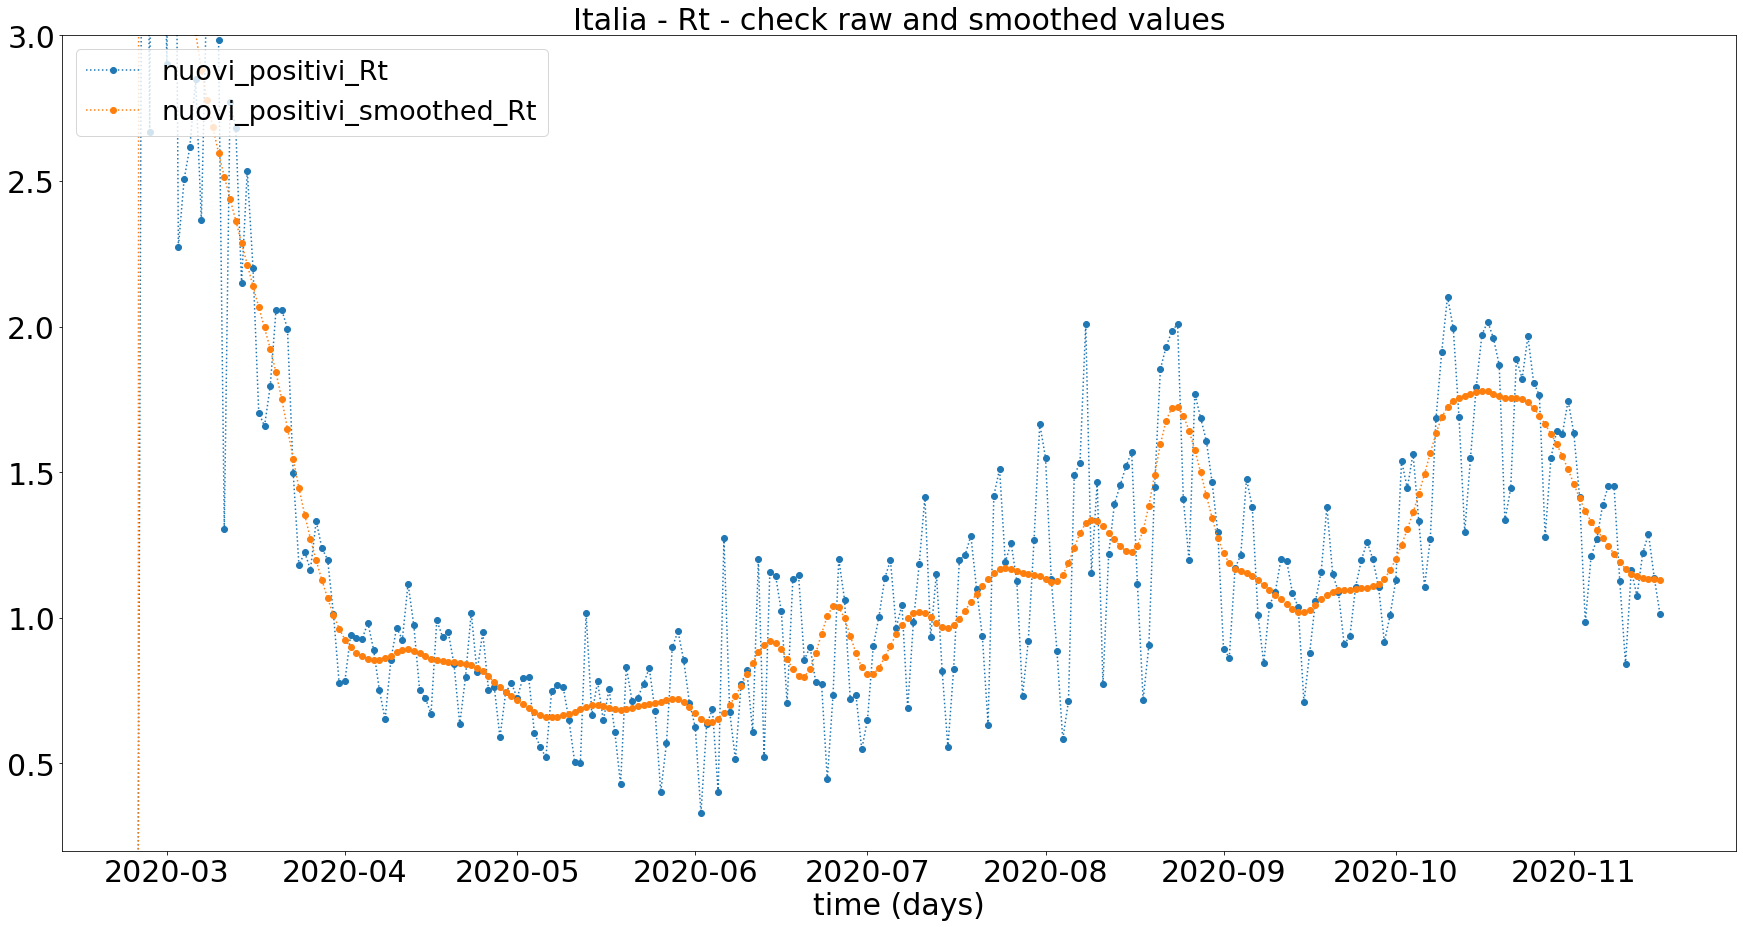

In [41]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.2,3)
)

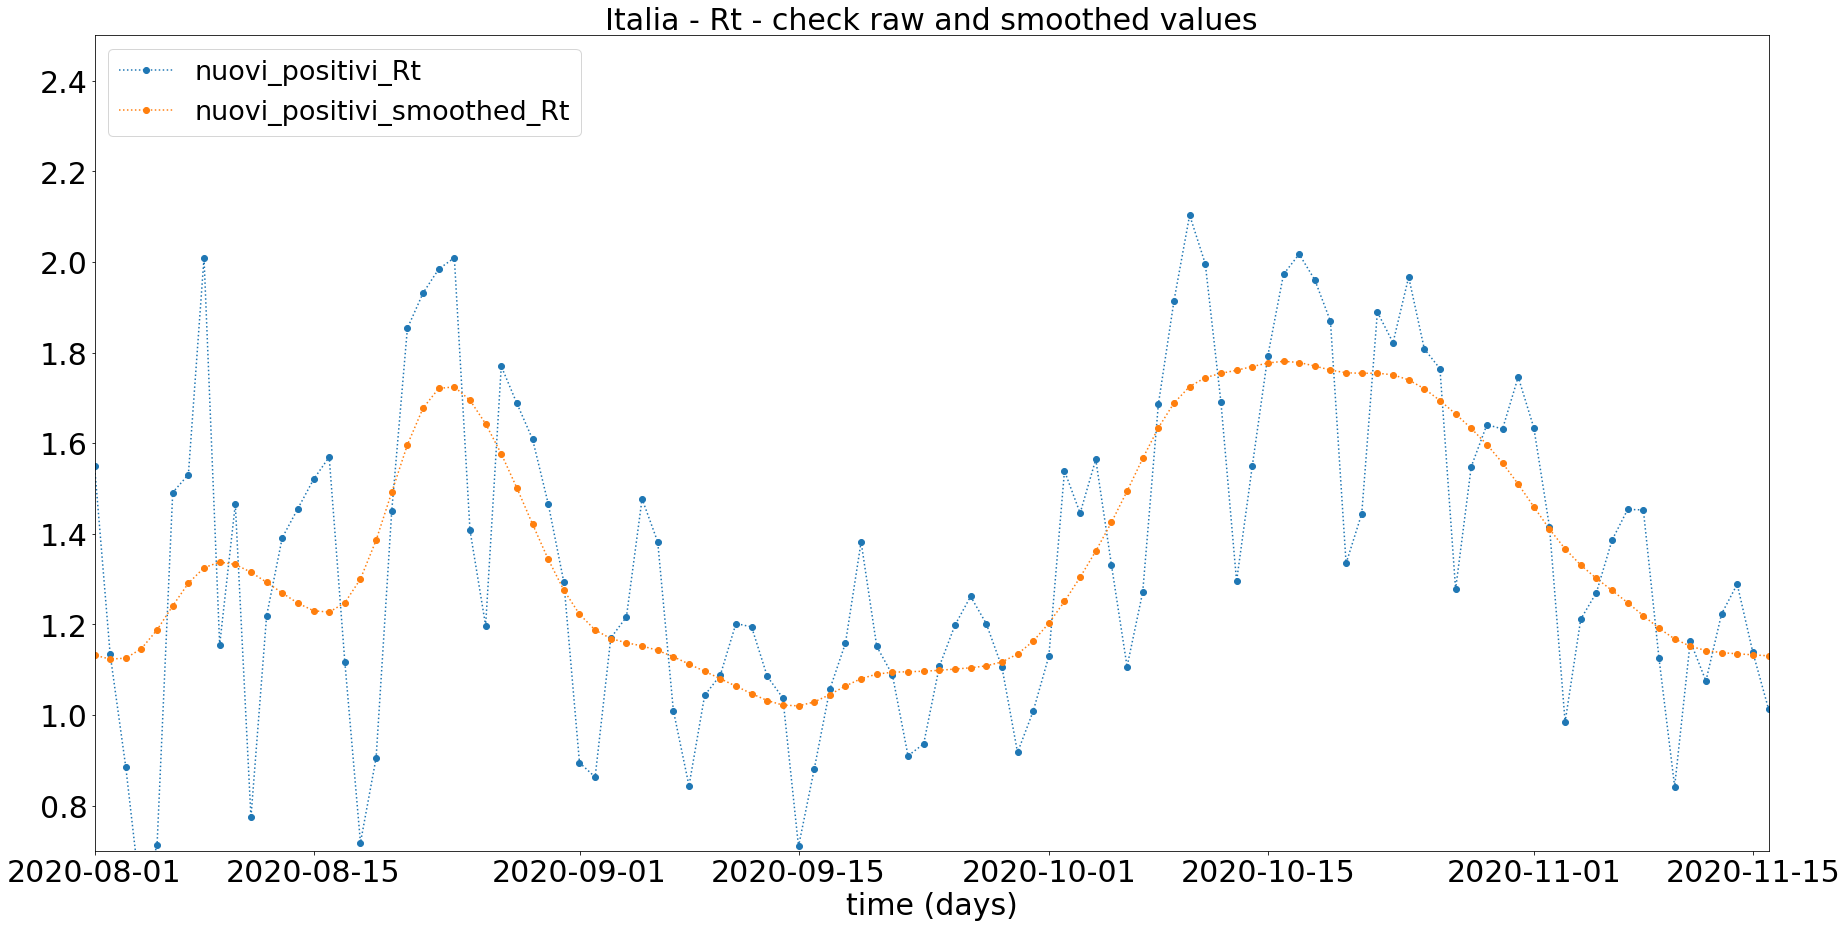

In [42]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.7,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

## Compare $R_t$ values computed on the 3 first differences

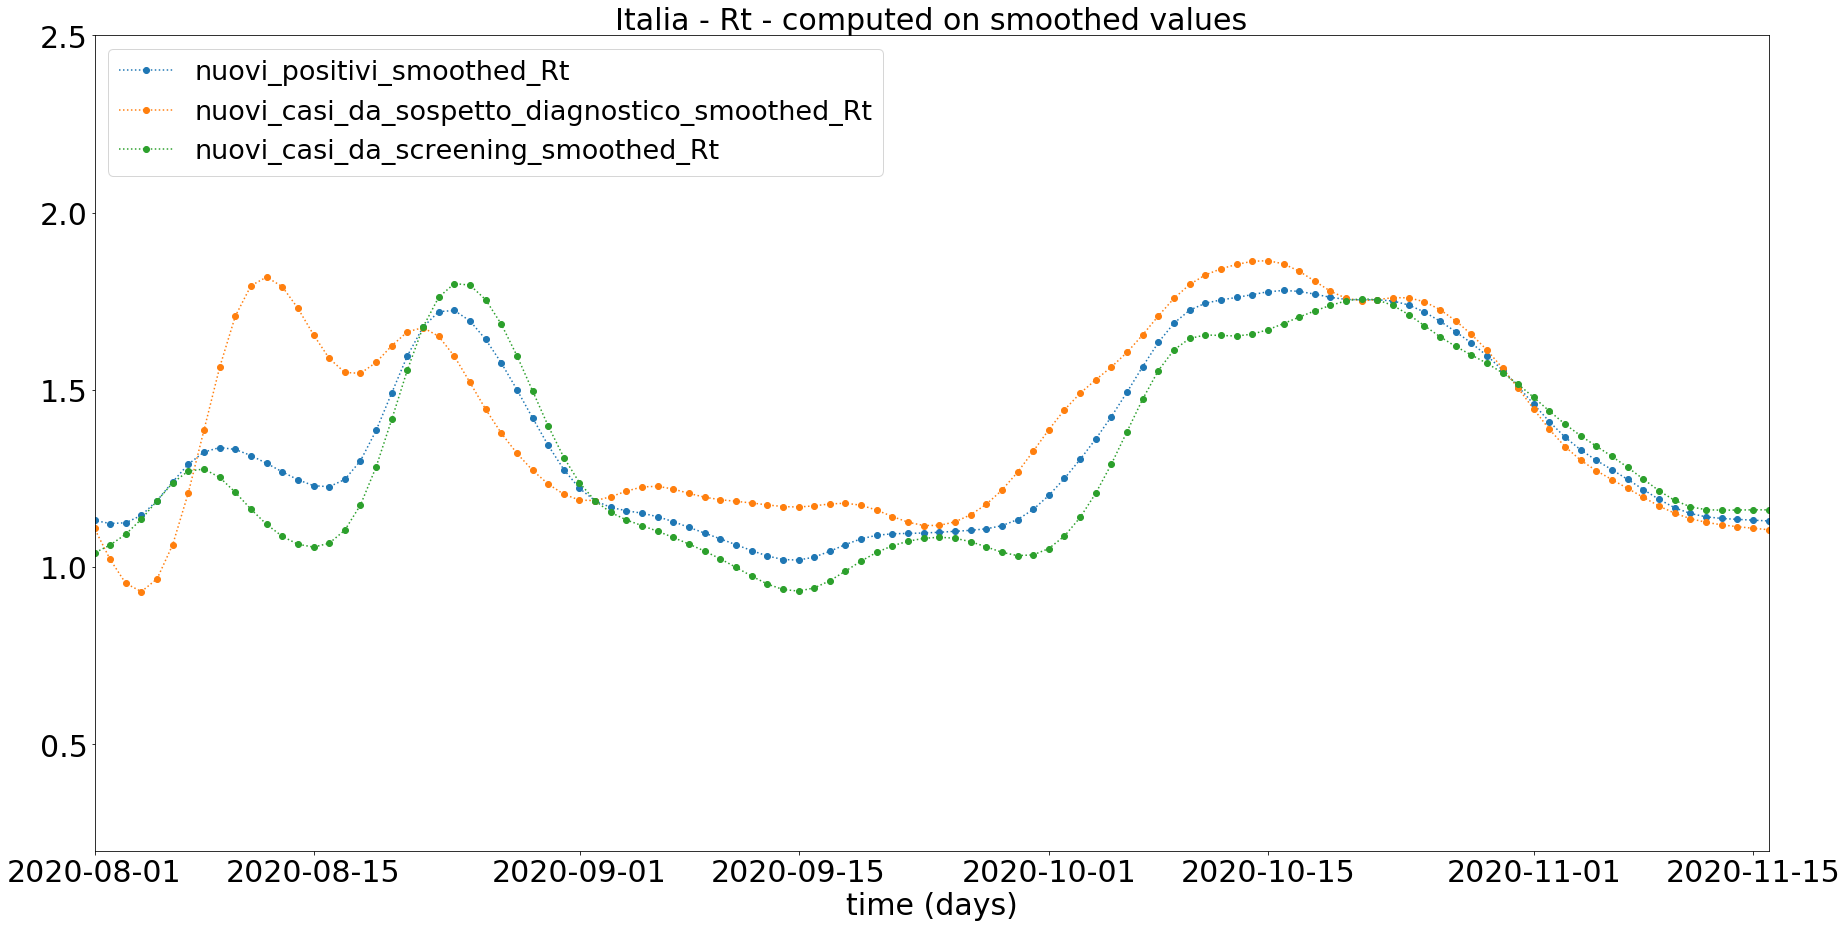

In [43]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

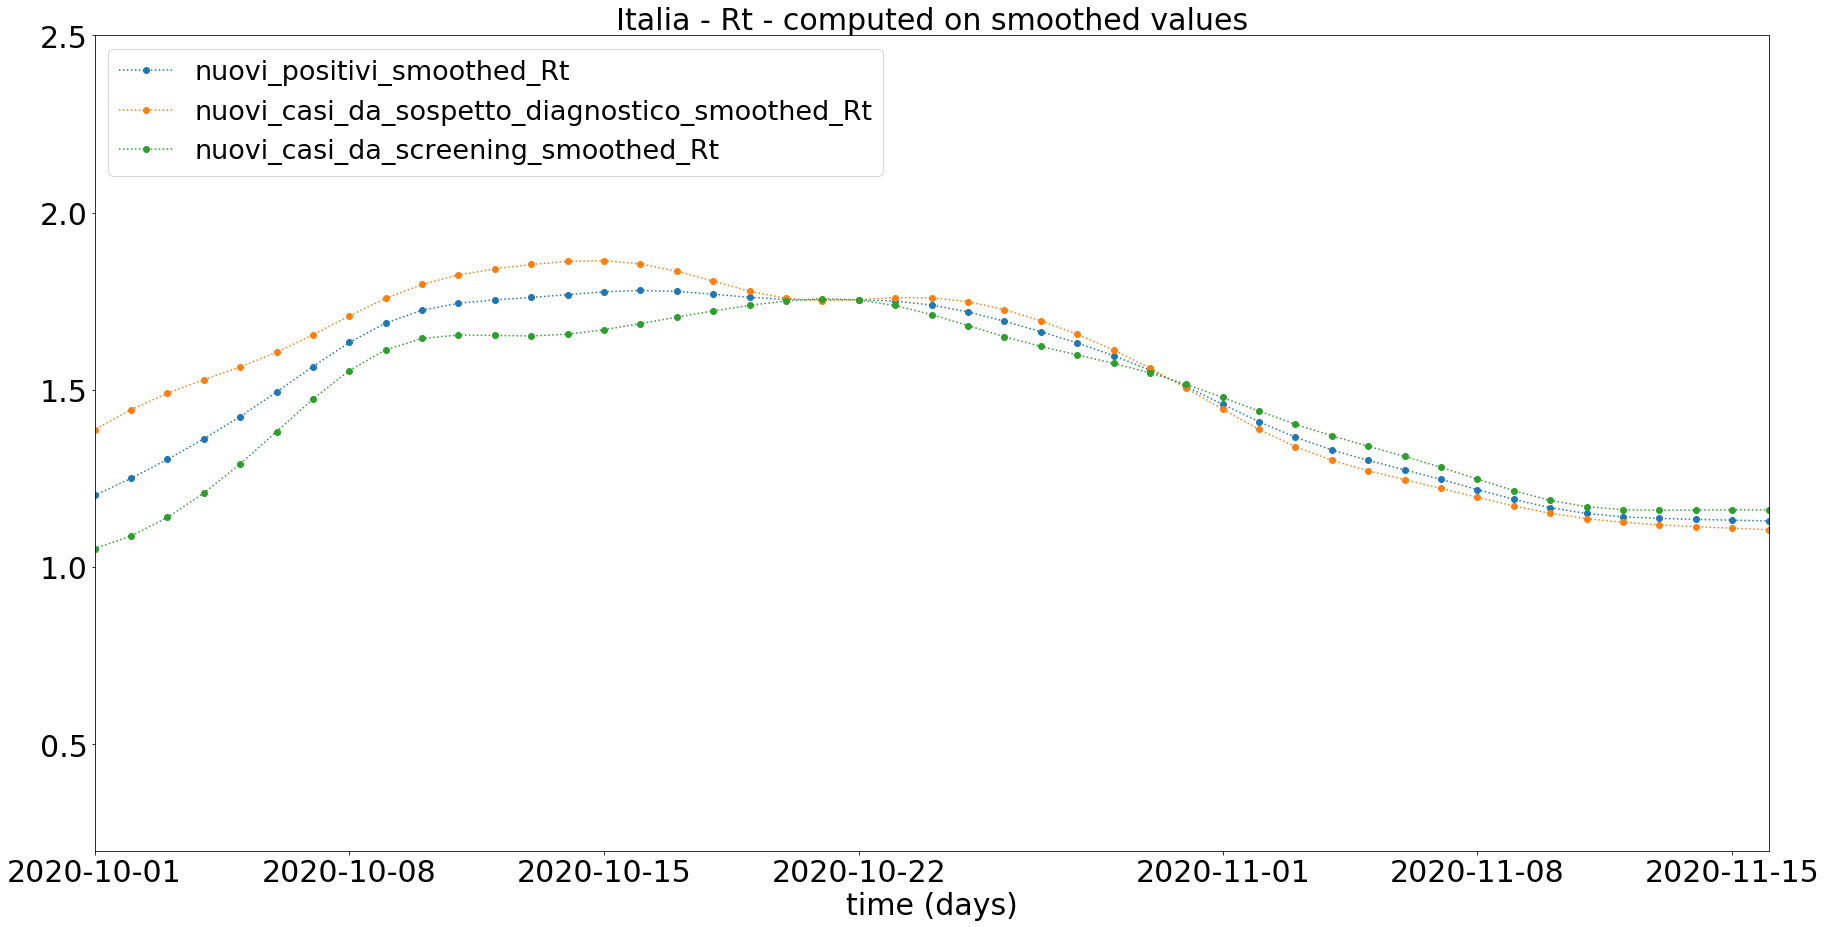

In [44]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,10,1),datetime(2020,11,16))
)

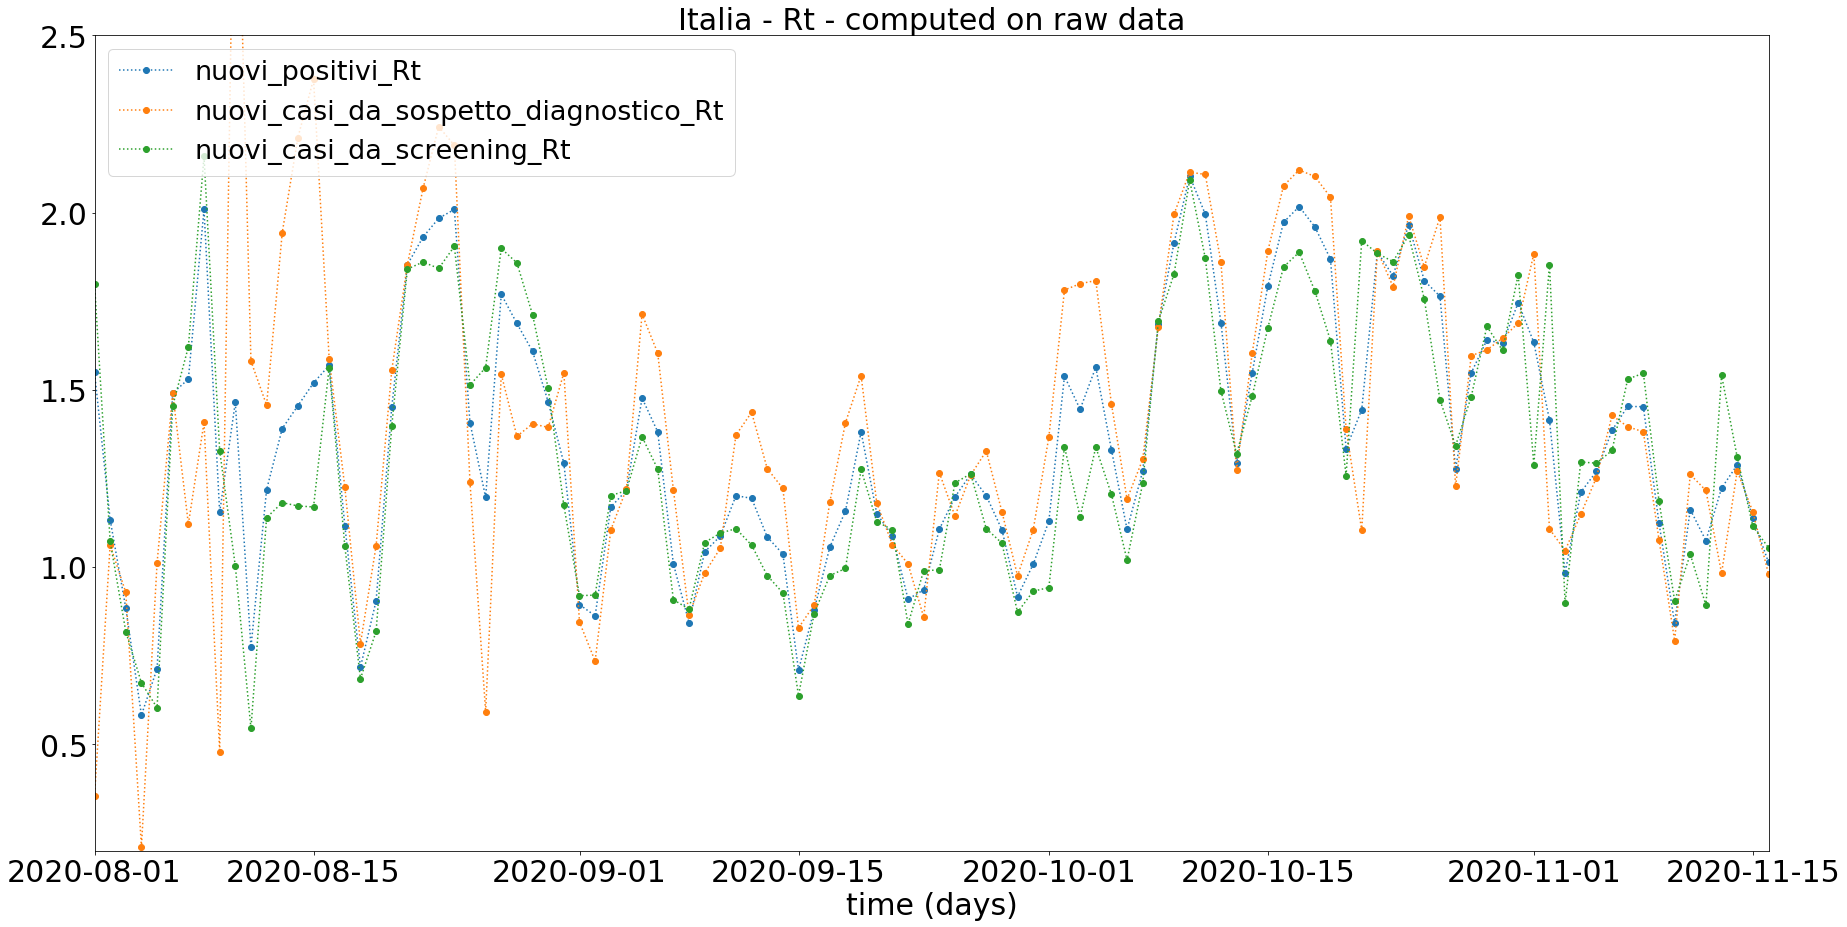

In [45]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_casi_da_sospetto_diagnostico_Rt',
        'nuovi_casi_da_screening_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

# Assess $R_t$ via perturbations

Let's add a perturbation $p_t$ to the original cumulative signal, and compute again the first difference:

$$\large{C_t = \sum_{s=1}^{t} I_t}$$

$$\large{\hat{C}_t = C_t + p_t}$$

$$\large{\hat{I}_t = \hat{C}_t-\hat{C}_{t-1}}$$


## Rate perturbation

The constant rate pertubation is defined as:

$$\large{p_{t+1} = p_t  (1+r_t)} $$

where:
- $r_t$ is the growth rate of the perturbation; it can be a function of time.

In [46]:
def growth(v,rate, zerosteps, steps):
    assert(zerosteps < steps)
    if isinstance(rate, Number):
        ratefunc = lambda s: rate
    elif callable(rate):
        ratefunc = rate
    else:
        raise Exception("rate must be either a number or a function")
    for s in range(steps):
        if s <= zerosteps:
            yield 0.
        else:
            r = ratefunc(s)
            v = v * (1. + r)
            yield v

In [48]:
p0 = 40.
rate=0.1
perturbation = pd.Series(growth(p0,rate, FIRST_CASI_SOSP_DIAGNOSTICO, TIMESTEPS))

cumulative_hat = italy_raw_data.casi_da_sospetto_diagnostico + perturbation

nuovi_casi_hat = smooth_differentiate(
    cumulative_hat,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

nuovi_perturbation = smooth_differentiate(
    perturbation,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

Rt_nuovi_casi_hat = Rt(nuovi_casi_hat, alpha=alpha, beta=beta)
Rt_perturbation = Rt(nuovi_perturbation, alpha=alpha, beta=beta)

italy_raw_data['perturbation_Rt'] = Rt_perturbation
italy_raw_data.perturbation_Rt.fillna(0, inplace=True)

italy_raw_data['casi_da_sospetto_diagnostico_smoothed_perturbed_Rt'] = Rt_nuovi_casi_hat
italy_raw_data.casi_da_sospetto_diagnostico_smoothed_perturbed_Rt.fillna(0, inplace=True)


TIC R2: 0.9999909137811084
TIC R2: 0.9999953981464965


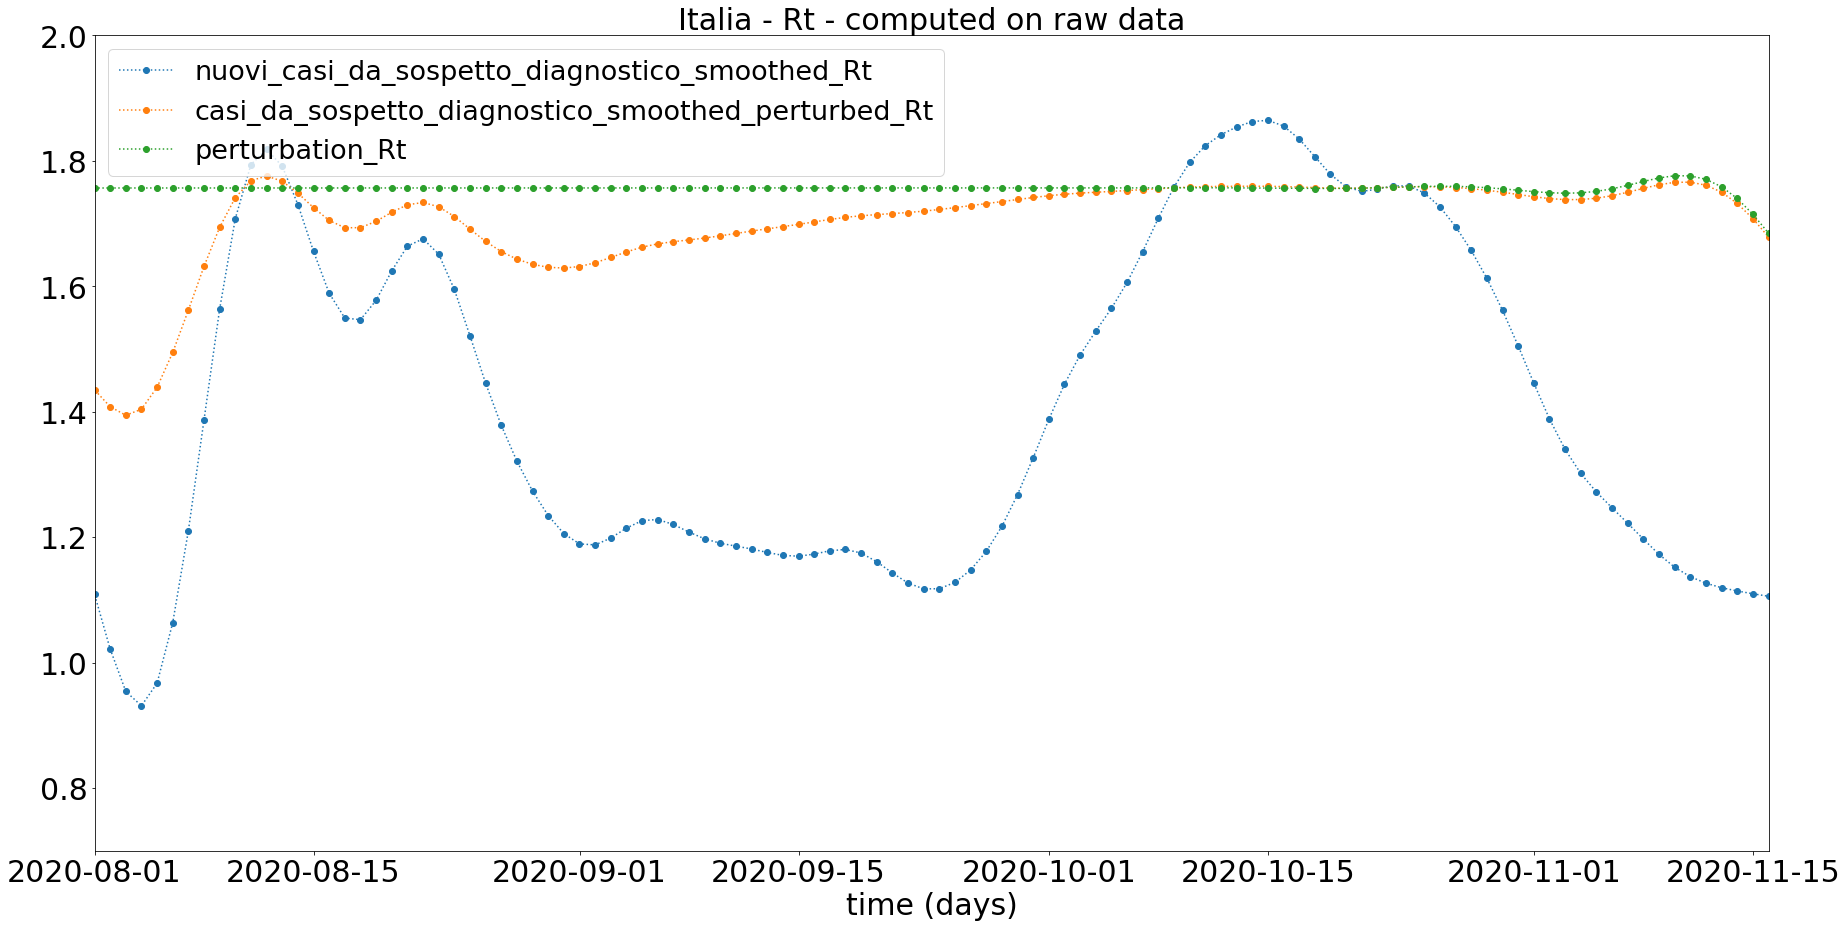

In [49]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'casi_da_sospetto_diagnostico_smoothed_perturbed_Rt',
        'perturbation_Rt'
    ],
    ylim=(0.7,2),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

# Comparison of ISS and realtime Rt values

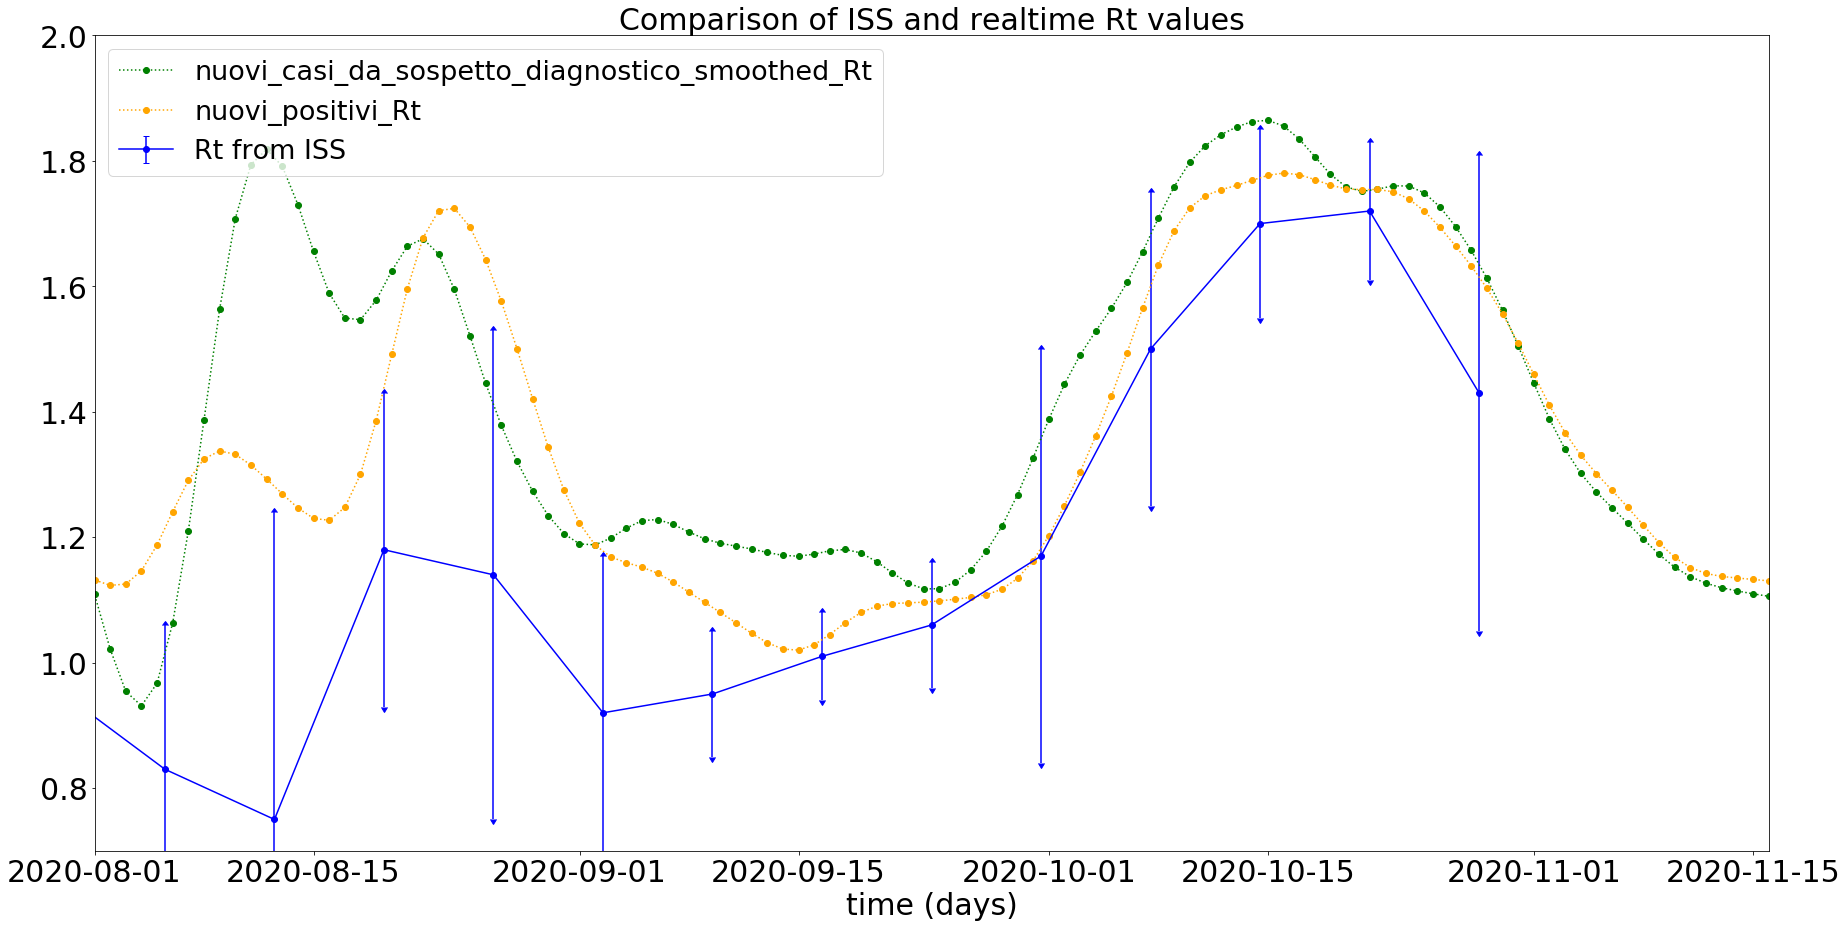

In [58]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Comparison of ISS and realtime Rt values', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)

ax1.set_ylim(0.7,2)
ax1.set_xlim(datetime(2020,8,1),datetime(2020,11,16))

ax1.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_casi_da_sospetto_diagnostico_smoothed_Rt, 
    label='nuovi_casi_da_sospetto_diagnostico_smoothed_Rt', 
    linestyle=':', marker='o', color = 'green'
)

ax1.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_positivi_smoothed_Rt, 
    label='nuovi_positivi_Rt', 
    linestyle=':', marker='o', color = 'orange'
)

ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS',
    marker='o', color = 'blue'
)


_ = ax1.legend(fontsize=27, loc='upper left')    